<a href="https://colab.research.google.com/github/luperezsal/DaVincis/blob/master/Main2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluación de prácticas | Da-Vincis

En esta evaluación de prácticas se implementará una solución para el reto Da-Vincis, propuesto por la organización [IberLEF](https://sites.google.com/view/iberlef2022).

Este reto ([IberLEF Davincis](https://codalab.lisn.upsaclay.fr/competitions/2638)) consiste en clasificar tweets, redactados en español, que pertenecen a una serie de categorías. Cada tweet puede pertenecer a varias de estas clases, por lo que nos enfrentamos ante un problema de clasificación multietiqueta.

Para lograr este objetivo se hará uso de una arquitecturas transformer ([Bert Base Multilingual Uncased Sentiment](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment)) que ha sido entrenada en cinco idiomas.

El repositorio donde está alojado este notebook junto con las versiones que se han ido implementando se puede encontrar en [GitHub](https://github.com/luperezsal/DaVincis).

Como bibliografía consultada podemos listar las siguientes:


- [Bert for sentiment analysis of chatbot conversations](https://engati.medium.com/bert-for-sentiment-analysis-of-chatbot-conversations-fbfdc392d68a)

- [Multi-label Text Classification Using Transfer Learning powered by “Optuna”](https://www.analyticsvidhya.com/blog/2022/01/multi-label-text-classification-using-transfer-learning-powered-by-optuna/)

- [Multi-label classification with BERT](https://data4thought.com/toxic_comments_transformer.html)

In [225]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [226]:
DATA_PATH = 'https://raw.githubusercontent.com/luperezsal/DaVincis/master/data/'

TRAINING_DATA_PATH = f"{DATA_PATH}training_data/"
TEST_DATA_PATH = f"{DATA_PATH}test_data/"

In [227]:
TASK = 2

# Load Data

In [228]:
text_col  = 'tweet'
class_col = 'incident'

# Train Data
X_train = pd.read_csv(f"{TRAINING_DATA_PATH}train_data.csv", names = [text_col])
Y_train_1 = pd.read_csv(f"{TRAINING_DATA_PATH}train_labels_subtask_1.csv", names = [class_col])
Y_train_2 = pd.read_csv(f"{TRAINING_DATA_PATH}train_labels_subtask_2.csv", header = None)

# Trial Data
X_trial = pd.read_csv(f"{TRAINING_DATA_PATH}trial_data.csv", names = [text_col])
Y_trial_1 = pd.read_csv(f"{TRAINING_DATA_PATH}trial_labels_subtask_1.csv", names = [class_col])
Y_trial_2 = pd.read_csv(f"{TRAINING_DATA_PATH}trial_labels_subtask_2.csv", header = None)

# Test Data
X_test = pd.read_csv(f"{TEST_DATA_PATH}test_data.csv", names = [text_col])

In [229]:
Y_train_2_labeled = Y_train_2.idxmax(axis=1)
Y_trial_2_labeled = Y_trial_2.idxmax(axis=1)

### Analysis

En primer lugar haremos un análisis exploratorio de los datos. Este es un paso importante ya que es necesario conocer la distribución de clases previamente a entrenar el modelo. Si disponemos de un conjunto de datos no balanceado, el modelo no generalizará correctamente ya que tenderá a predecir aquellas clases más numerosas en el conjunto de datos. Por este motivo se mostrará en un histograma el número de ocurrencias de cada clase.

A continuación se transforman las etiquetas de entrenamiento de forma `one-hot` a formato String para realizar una representación interpretable de las clases contenidas en el dataset.

In [230]:
Y_train_2_labeled[Y_train_2_labeled == 0] = 'Accident'
Y_train_2_labeled[Y_train_2_labeled == 1] = 'Homicide'
Y_train_2_labeled[Y_train_2_labeled == 2] = 'None of the above'
Y_train_2_labeled[Y_train_2_labeled == 3] = 'Theft'
Y_train_2_labeled[Y_train_2_labeled == 4] = 'Kidnapping'

None of the above    1798
Accident             1125
Homicide              244
Theft                 157
Kidnapping             38
dtype: int64

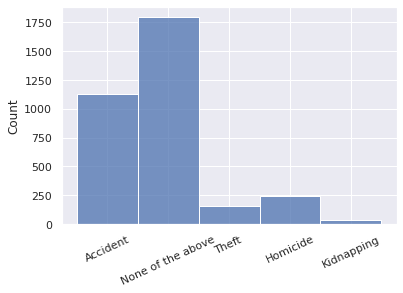

In [231]:
sns.set(style="darkgrid")
histogram = sns.histplot(Y_train_2_labeled)
histogram.tick_params(axis='x', rotation=25)

Y_train_2_labeled.value_counts()

Como se puede observar, la distribución de clases difieren mucho entre ellas, por lo que será necesario aplicar alguna técnica de Resampling para que el entrenamiento del modelo sea balanceado.

A continuación se muestran algunos ejemplos pertenecientes a cada una de las clases:

In [232]:
sample_index = Y_train_2_labeled[Y_train_2_labeled == 'Accident'].index[15]
print(f"Accident example: {X_train.loc[sample_index][text_col]}\n")

sample_index = Y_train_2_labeled[Y_train_2_labeled == 'Homicide'].index[15]
print(f"Homicide example: {X_train.loc[sample_index][text_col]}\n")

sample_index = Y_train_2_labeled[Y_train_2_labeled == 'None of the above'].index[15]
print(f"None of the above: {X_train.loc[sample_index][text_col]}\n")

sample_index = Y_train_2_labeled[Y_train_2_labeled == 'Theft'].index[15]
print(f"Theft: {X_train.loc[sample_index][text_col]}\n")

sample_index = Y_train_2_labeled[Y_train_2_labeled == 'Kidnapping'].index[15]
print(f"Kidnapping: {X_train.loc[sample_index][text_col]}")

Accident example: Nuevo Accidente, carril izquierdo bloqueado en #SeDallas en la I-20 WB en JJ Lemmon Rd, deténgase y regrese el tráfico a Trinity River Brg  https://t.co/6XRbCfL48n

Homicide example: 📹 #VIDEOS | Ola de violencia en #Oaxaca: asesinan a magistrado, a una familia y a tres mujeres  https://t.co/CSgnsxcUD1  https://t.co/CgP46rgPLJ

None of the above: #Seguridad 🚨🛑 Detuvo policía municipal a dos hombres por robo a casa habitación, en #Puebla. En la acción se recuperaron computadoras portátiles, un equipo de audio, un dispositivo de comunicación móvil, entre otros artículos. Urbano| Noticias  https://t.co/xXKSnVjz8k...  https://t.co/HcoPbEpPLk

Theft: #02Julio #Comparte  ¡Ayudemos a recuperarlo!  La mañana de este viernes, se informó el robo de un vehículo Nissan, Tsuru, que es taxi del sitio Ejecutivo, con número económico 120, en la colonia Morelos de Jiutepec, con placas de circulación A671LTH.  https://t.co/RTs0mMjfkB

Kidnapping: Myron Eugene Johnson de 26 años está sie

In [233]:
Y_train_2.columns = ['0', '1', '2', '3', '4']

# Resampling

Obtenemos las observaciones que contienen más de una clase para que no se vean afectadas por el undersampling. Sabremos que una clase es multi-etiqueta si la suma de la pertenencia a cada clase de cada observación es mayor que 1.

In [234]:
multilabel_data_index = Y_train_2[Y_train_2.sum(axis=1) > 1].index

multilabel_data = pd.DataFrame()

multilabel_data[text_col] = X_train.loc[multilabel_data_index]
multilabel_data[Y_train_2.columns] = Y_train_2.loc[multilabel_data_index]

Obtenemos las muestras que pertenecen únicamente a una clase para poder aplicar el undersampling sobre ellas, igualando el número de muestras a la clase `Homicidio`.

In [235]:
train = X_train[Y_train_2.sum(axis=1) == 1]

train[Y_train_2.columns] = Y_train_2

In [236]:
from sklearn.utils import resample

zero_class   = train[train['0'] == 1]
first_class  = train[train['1'] == 1]
second_class = train[train['2'] == 1]
third_class  = train[train['3'] == 1]
fourth_class = train[train['4'] == 1]

zero_class_downsampled = resample(zero_class,
                                  replace=True,
                                  n_samples=len(third_class),
                                  random_state=42)

first_class_downsampled = resample(first_class,
                                    replace=True,
                                    n_samples=len(third_class),
                                    random_state=42)

second_class_downsampled = resample(second_class,
                                    replace=True,
                                    n_samples=len(third_class),
                                    random_state=42)

third_class_downsampled = resample(third_class,
                                    replace=True,
                                    n_samples=len(third_class),
                                    random_state=42)

fourth_class_downsampled = resample(fourth_class,
                                    replace=True,
                                    n_samples=len(third_class),
                                    random_state=42)


train = pd.concat([zero_class_downsampled,
                    first_class_downsampled,
                    second_class_downsampled,
                    third_class_downsampled,
                    fourth_class_downsampled])

train

,tweet,0,1,2,3,4
2597,Aún no identifican a la persona sin vida en el...,1,0,0,0,0
3319,¡LAMENTABLE NOTICIA! Integrantes del Conjunto ...,1,0,0,0,0
3155,"Esta noche se registra un accidente múltiple, ...",1,0,0,0,0
350,Accidente en Cuautla deja dos lesionados htt...,1,0,0,0,0
1391,#ATENCIÓN 🔴 | Un aparatoso accidente se regist...,1,0,0,0,0
...,...,...,...,...,...,...
2718,No es meme. La cara de Bottas cuando le mostra...,0,0,0,0,1
2718,No es meme. La cara de Bottas cuando le mostra...,0,0,0,0,1
1839,DETIENEN A UN HOMBRE BAJO EL DELITO DE SECUEST...,0,0,0,0,1
701,#Titulares en #MaravillaInforma ||ELN confirmó...,0,0,0,0,1


Añadimos las clases originales multi.etiqueta al nuevo conjunto resampleado.

In [237]:
train = pd.concat([train,
                   multilabel_data])

Dividimos el Dataframe en contenido y etiquetas y se muestra la cantidad de valores de cada clase.

In [238]:
X_train = train.loc[:, ~train.columns.isin(Y_train_2.columns)]
Y_train_2 = train[Y_train_2.columns]

Y_train_2.value_counts()

0  1  2  3  4
0  0  0  0  1    156
         1  0    156
      1  0  0    156
   1  0  0  0    156
1  0  0  0  0    156
0  1  0  1  0     22
1  1  0  0  0     16
0  1  0  0  1      6
   0  0  1  1      1
dtype: int64

# Transformer

En esta sección se descargará un modelo preentrenado de transformers, concretamente [Bert Base Multilingual Uncased Sentiment](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment) definiendo su configuración.

En primer lugar se incluyen las librerías y dependencias necesarias para los elementos que se usarán de Transformers.

In [239]:
# instalar librerías. Esta casilla es últil por ejemplo si se ejecuta el cuaderno en Google Colab
# Note que existen otras dependencias como tensorflow, etc. que en este caso se encontrarían ya instaladas
%%capture
!pip install transformers==4.2.1

import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TFAutoModel, TFAutoModelForSequenceClassification


print('Done!')

In [250]:
cfg = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg['number_of_additional_features'] = 5319
cfg['num_labels'] = 5

A continuación se define el método que transformará el input de entrada (tweets en texto plano) a la entrada comprensible por el modelo, es decir, a embeddings, máscaras de atención y matrices TFIDF.

In [251]:
import nltk
from nltk.corpus import stopwords

Y_train = Y_train_1 if TASK == 1 else Y_train_2
Y_trial = Y_trial_1 if TASK == 2 else Y_train_2

nltk.download('stopwords')

# función auxiliar para obtener tensores de entrada al modelo a partir del texto
def get_model_inputs(cfg, data):

  encodings = cfg['tokenizer'](data,
                               truncation = True,
                               padding = 'max_length',
                               max_length = cfg['max_length'],
                               return_tensors = cfg['framework']).data

  # obtener representación tf-idf de cada instancia
  tfidf = cfg['vectorizer'].transform(data)
  tfidf_t = tf.convert_to_tensor(tfidf.toarray(), dtype=tf.float32)

  inputs = {'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask'],
            'tfidf': tfidf_t
            }
          
  return inputs


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
import plotly.figure_factory as ff

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Definición del modelo

Se define el modelo de clasificación multi-etiqueta en base al modelo pre-entrenado. Para ello, se hará uso de una última capa densa con la función de activación sigmoide.

In [252]:
def get_model_graph(cfg):
  # transformer = TFDistilBertModel.from_pretrained(cfg['transformer_model_name'], return_dict=False).distilbert
  transformer = TFAutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment",
                                                                     output_hidden_states = True)


  input_ids = tf.keras.layers.Input(shape=(cfg['max_length'],), name='input_ids', dtype='int32')


  input_masks = tf.keras.layers.Input(shape=(cfg['max_length'],), name='attention_mask', dtype='int32') 


  input_tfidf = tf.keras.layers.Input(shape = (cfg['number_of_additional_features'],),
                                      name = 'tfidf',
                                      dtype = 'float32') 

  transformer_output = transformer(input_ids,
                                    attention_mask = input_masks)

  last_hidden_state = transformer_output.hidden_states[-1]

  transformes_cls_embedding = tf.keras.layers.Lambda(lambda seq: seq[:,0,:], name='lambda')(last_hidden_state)

  # return last_hidden_state
  # concatenar embedding del token [CLS] con el vector de rasgos adicionales.
  features = tf.keras.layers.concatenate([transformes_cls_embedding, input_tfidf], name='concatenate')

  # establecer algunos hiper-parámetros del modelo
  initializer_range = 0.02
  hiden_units = 768
  seq_classif_dropout=0.2
  initializer = tf.keras.initializers.TruncatedNormal(stddev=initializer_range)

  # crear pre_classifier, establecer como su entrada los rasgos concatenados (features).
  pre_classifier = tf.keras.layers.Dense(hiden_units,
                                         kernel_initializer = initializer,
                                         activation = 'relu',
                                         name = 'pre_classifier')(features) 

  # crear dropout layer y establecer como su entrada la salida de pre_classifier.
  dropout_layer = tf.keras.layers.Dropout(rate = seq_classif_dropout,
                                          name ='dropout')(pre_classifier)  

  # crear classifier layer y establecer como su entrada la salida de la capa dropout.
  classifier = tf.keras.layers.Dense(cfg['num_labels'],
                                     kernel_initializer = initializer,
                                     name = 'classifier',
                                     activation = 'sigmoid')(dropout_layer)

  return input_ids, input_masks, input_tfidf, classifier

print('Done!')

Done!


# Instanciar tokenizador, tf-idf vectorizer, etc.

Se inicializan los tokenizadores para tratar las frases de entrada, así como los vectorizadores y binarizadores de etiquetas.

In [253]:
from sklearn import preprocessing

cfg['tokenizer'] = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# instanciar TfidfVectorizer
cfg['vectorizer'] = TfidfVectorizer(stop_words = stopwords.words('spanish'),
                                    max_features = cfg['number_of_additional_features'])

# entrenar TfidfVectorizer
cfg['vectorizer'].fit(X_train[text_col].to_list())

cfg['label_binarizer'] = preprocessing.LabelBinarizer() 

# entrenar LabelBinarizer
cfg['label_binarizer'].fit(Y_train)

LabelBinarizer()

# Inicialización de entrada

Se transforman los datos de entrada a los inputs del transformer, que constan de la tokenización del texto, las máscaras y el vectorizador TFIDF.

In [254]:
train_inputs = get_model_inputs(cfg, X_train[text_col].to_list())
trial_inputs = get_model_inputs(cfg, X_trial[text_col].to_list())

In [255]:

def multi_label_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """For multi-label classification, one has to define a custom
    acccuracy function because neither tf.keras.metrics.Accuracy nor
    tf.keras.metrics.CategoricalAccuracy evaluate the number of 
    exact matches.

    :Example:
    >>> from tensorflow.keras import metrics
    >>> y_true = tf.convert_to_tensor([[1., 1.]])
    >>> y_pred = tf.convert_to_tensor([[1., 0.]])
    >>> metrics.Accuracy()(y_true, y_pred).numpy()
    0.5
    >>> metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    1.0
    >>> multi_label_accuracy(y_true, y_pred).numpy()
    0.0
    """   
    y_pred = tf.math.round(y_pred)
    exact_matches = tf.math.reduce_all(y_pred == y_true, axis=1)
    exact_matches = tf.cast(exact_matches, tf.float32)
    return tf.math.reduce_mean(exact_matches)

Se define el método que configurará el modelo. Además, se añaden las métricas de clasificación multi-etiqueta para mostrarlas durante el entrenamiento.

In [256]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC

def configure_model(input_ids, input_masks, input_tfidf, classifier):
  # definir algoritmo de optimización
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

  # definir función loss. Debe cuidarse que sea coherente con la salida esperada del modelo (vector de num_labels elementos)
  # y el formato de los ejemplos (vector one-hot de num_labels componentes para codificar las categorías)
  if (TASK == 1):
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  else :
      metric = 'categorical_crossentropy'
      loss = BinaryCrossentropy()

  # crear el modelo
  model = tf.keras.Model(inputs=[input_ids, input_masks, input_tfidf], outputs=classifier, name='distilbert-custom') # conectar todos los nodos en un modelo
  
  metrics = [
      multi_label_accuracy,
      "binary_accuracy", 
      AUC(name="average_precision", curve="PR", multi_label=True)
  ]

  model.compile(loss = loss,
                metrics = metrics,
                optimizer = optimizer)

  return model

print('Done!')

Done!


Se llama al método de inicialización del modelo y se muestra la arquitectura de la red por pantalla.

In [257]:
input_ids, input_masks, input_tfidf, classifier = get_model_graph(cfg)
model = configure_model(input_ids, input_masks, input_tfidf, classifier)

# imprimir sumario del modelo 
model.summary()


print('Done!')

Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
The parameter

Model: "distilbert-custom"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  167360261  ['input_ids[0][0]',              
 ation_4 (TFBertForSequenceClas  rOutput(loss=None,               'attention_mask[0][0]']         
 sification)                    logits=(None, 5),                                                 
                                 hidden_states=((No                               

# Train model

A continuación se realiza el fine tunning del transformer para el dominio específico de nuestro problema, es decir, la clasificación multi-etiqueta de los tweets.

In [267]:
from tqdm import tqdm

# gpu_options = tf.GPUOptions(allow_growth=True)
# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

epochs_max = 2
epochs_to_save = 1
batch_size = 8

# ciclo de entrenamiento y guardar checkpoints
for epoch in tqdm(range(0, epochs_max, epochs_to_save)):
    print('Training model, epochs {0} - {1}'.format(epoch+1, epoch+epochs_to_save))
    
    # entrenar el modelo. Opcionalmente, se puede suministrar datos de validación => validation_data=(val_inputs,val_blabels_t )
    history = model.fit(train_inputs,
                        y = Y_train_2,
                        epochs = epochs_to_save,
                        batch_size = batch_size,
                        validation_data = (trial_inputs, Y_trial_2))
    
    model.save_weights(f"task_{TASK}", save_format="tf")
    
print('Done!')

  0%|          | 0/2 [00:00<?, ?it/s]

Training model, epochs 1 - 1
104/104 [==============================] - 96s 922ms/step - loss: 0.3636 - multi_label_accuracy: 0.4844 - binary_accuracy: 0.8570 - average_precision: 0.6188 - val_loss: 0.3804 - val_multi_label_accuracy: 0.3571 - val_binary_accuracy: 0.8360 - val_average_precision: 0.5858


 50%|█████     | 1/2 [02:31<02:31, 151.20s/it]

Training model, epochs 2 - 2
104/104 [==============================] - 97s 932ms/step - loss: 0.3246 - multi_label_accuracy: 0.5974 - binary_accuracy: 0.8807 - average_precision: 0.7020 - val_loss: 0.3662 - val_multi_label_accuracy: 0.5536 - val_binary_accuracy: 0.8440 - val_average_precision: 0.6336


100%|██████████| 2/2 [05:02<00:00, 151.14s/it]

Done!


# Results

En este punto se mostrarán los resultados del modelo entrenado para cada uno de los conjuntos de datos: entrenamiento, validación y test.

## Train Data

A continuación se mostrarán los resultados de la predicción del modelo sobre los datos de entrenamientp. Unos resultados prometedores sobre este conjunto de datos no implican un buen rendimiento del modelo. Esta primera clasificación nos servirá para tener una primera referencia de cómo ha entrenado el modelo. 

In [268]:
data = X_train
true_labels = Y_train_2

inputs = get_model_inputs(cfg, data[text_col].to_list())

scores = model.predict(inputs)
labels = cfg['label_binarizer'].inverse_transform(scores)

print(classification_report(true_labels, labels))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77       172
           1       0.81      0.70      0.75       200
           2       0.79      0.63      0.70       156
           3       0.87      0.59      0.70       179
           4       0.92      0.94      0.93       163

   micro avg       0.83      0.72      0.77       870
   macro avg       0.83      0.73      0.77       870
weighted avg       0.83      0.72      0.77       870
 samples avg       0.76      0.75      0.76       870



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[[612,  41],
        [ 40, 132]],

       [[591,  34],
        [ 59, 141]],

       [[643,  26],
        [ 58,  98]],

       [[630,  16],
        [ 74, 105]],

       [[648,  14],
        [  9, 154]]])

Como podemos observar en el reporte de clasificación, generalmente obtenemos buenos resultados para todas las clases, por lo que se puede deducir que el modelo ha entrenado teniendo en cuenta todas las clases del conjunto de datos.

## Trial Data

En esta sección se evaluará el modelo respecto a los datos de validación que se han utilizado en la etapa de entrenamiento del modelo. Al disponer de las etiquetas verdaderas sobre este conjunto, se puede evaluar cómo generaliza con respecto a nuevos datos.

In [271]:
data = X_trial
true_labels = Y_trial_2

inputs = get_model_inputs(cfg, data[text_col].to_list())

scores = model.predict(inputs)
labels = cfg['label_binarizer'].inverse_transform(scores)

df = pd.DataFrame(labels, columns = ['0','1','2','3','4'])
df.value_counts()

print(classification_report(true_labels, labels))

              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.36      0.80      0.50         5
           2       1.00      0.37      0.54        27
           3       0.44      0.80      0.57         5
           4       1.00      0.50      0.67         2

   micro avg       0.63      0.57      0.60        51
   macro avg       0.69      0.66      0.60        51
weighted avg       0.80      0.57      0.59        51
 samples avg       0.58      0.57      0.57        51



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Observamos que la predicción de los elementos de validación no se corresponden con las métricas prometedoras del conjunto de entrenamiento como ya habíamos avanzado. No obstante, se podría considerar que no son malos resultados comparados con el resto de concursantes del [reto](https://codalab.lisn.upsaclay.fr/competitions/2638#results) respecto a este mismo conjunto de datos.

# Predicciones

En esta sección se facilita un método para testar el comportamiento del modelo. A modo de ejemplo se ofrece un tweet perteneciente al conjunto de datos de test para evaluar a qué categoría/s pertenece.

In [292]:
example_tweet = X_test.iloc[0]
print(f"Tweet de ejemplo: {example_tweet[text_col]}\n")

input = get_model_inputs(cfg, example_tweet.to_list())

scores = model.predict(input)
labels = cfg['label_binarizer'].inverse_transform(scores)

human_label = ['Accident', 'Homicide', 'None of the above', 'Theft', 'Kidnapping']

positions = np.where(labels == 1)[1]
mapped_indexes =  map(human_label.__getitem__, positions)

list(mapped_indexes)

Tweet de ejemplo: Un vehículo rodó varios metros por la pendiente de la carretera en el municipio de #Socha en #Boyacá.  Tras el accidente, el conductor quedó con algunas heridas y fracturas, mientras que el vehículo quedó semi destruido, varios semovientes que transportaba murieron en el lugar.  https://t.co/56DiOjd8z3



['Accident']

# Conclusiones

Como hemos podido comprobar, esta implementación del transformer para clasificación de instancias multietiqueta provee un rendimiento aceptable para las clases en comparación con la puntuación del resto de resultados del resto de participantes ([Resultados Competidores DaVincis](https://codalab.lisn.upsaclay.fr/competitions/2638#participate-submit_results)).

Para intentar mejorar esta implementación podría hacerse uso de arquitecturas `NAS` que busquen la mejor arquitectura para clasificación multi-etiqueta, o el uso de la librería `Optuna` para el mismo propósito. Otra opción interesante sería estudiar otra forma de balancear los datos, intentando remuestrear aquellas clases minoritarias o realizar el downsampling respecto al número de instancias de una clase más numerosa. Además, se podría buscar otro valor para el tamaño de batch, que por limitaciones de recursos de Google Colab se ha tenido que reducir hasta 8, aumentar este valor podría mejorar el rendimiento del modelo.

Lamentablemente, por limitaciones de tiempo, estas mejoras no se han podido implementar.

# Opinión Personal

Me ha gustado bastante esta práctica, el hecho de competir con otros usuarios buscando mejorar los resultados. Sin embargo, debido a limitaciones de tiempo de otras asignaturas y TFM, no le he podido dedicar todo el tiempo que me hubiera gustado para mejorarlo y observar mis resultados respecto al resto de participantes. Lamentablemente el concurso cerró hace un par de días y me he quedado con las ganas, así que estaré pendiente de los retos que se proponen a partir de ahora que tendré más tiempo libre.